## End to end speech recognition

- TIMIT base 
- LSTM and CTC to start

In [164]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
import numpy as np


## Base de données

In [165]:
import zipfile
import shutil
import gzip
from IPython.display import display, Audio 
import librosa
import datetime
import os 
import pandas as pd
import csv
import pickle as pkl

In [166]:
%%capture

def extract_zip_dir(dir_path, display_info=True):

    with zipfile.ZipFile(dir_path, 'r') as zip_dir:
        
        for member in zip_dir.namelist():
            if os.path.exists('.' + r'/' + member) or os.path.isfile('.' + r'/' + member):
                print(member, 'already exists.')
                pass
            else:
                #zip_dir.printdir()
                zip_dir.extractall()

        if display_info:
            with zipfile.ZipFile(dir_path, 'r') as zip_dir:
                for info in zip_dir.infolist():
                    print(info.filename)
                    print('\tModified:\t' + str(datetime.datetime(*info.date_time)))
                    print('\tSystem:\t\t' + str(info.create_system) + ' (0 = Windows, 3 = Unix)')
                    print('\tZIP version:\t' + str(info.create_version))
                    print('\tCompressed:\t' + str(info.compress_size) + ' bytes')
                    print('\tUncompressed:\t' + str(info.file_size) + ' bytes')


#Write a csv file to manipulate easilier the data
def create_csv_files(word_file_list,
                     txt_csv_file, audio_csv_file):

    word_file_list_df = pd.read_csv(word_file_list, header=None)

    try:

        if not ( os.path.isfile(txt_csv_file) and os.path.isfile(txt_csv_file) ):

            with open(txt_csv_file, 'w', newline='') as txt_file, open(audio_csv_file, 'w', newline='') as audio_file:

                writer_txt   = csv.writer(txt_file)
                writer_audio = csv.writer(audio_file)

                writer_txt.writerow(["index","test_or_train","dialect_region","speaker_id","filename",
                                     "path_from_data_dir",
                                     "is_audio","is_word_file","is_phonetic_file","is_sentence_file"])

                writer_audio.writerow(["index","test_or_train","dialect_region","speaker_id","filename",
                                       "path_from_data_dir",
                                       "is_audio","is_word_file","is_phonetic_file","is_sentence_file"])

                for line in range(len(word_file_list_df)):
                    
                    index = line

                    # Looking for info in the line to fill the CSV
                    line_str = word_file_list_df.iloc[line][0]

                    if "TEST" in line_str:
                        test_or_train = "TEST"
                    else:
                        test_or_train = "TRAIN"
                    dialect_region    = "DR" + line_str[line_str.find("/DR") + 3]
                    speaker_id        = line_str[line_str.find(dialect_region) + 4 : line_str.find(dialect_region) + 9]
                    file_name         = line_str[line_str.find(speaker_id) + 6 :]
                    # Remove suffix WRD from the name to replace it by TXT
                    if ".WRD" in file_name:
                        file_name = file_name.replace(".WRD", "")

                    txt_file_name     = file_name + ".TXT.gz"
                    audio_file_name   = file_name + ".WAV.gz"

                    path_from_data_dir_txt   = "./TIMIT/" + test_or_train + "/" + dialect_region + "/" + speaker_id + "/" + txt_file_name 
                    path_from_data_dir_audio = "./TIMIT/" + test_or_train + "/" + dialect_region + "/" + speaker_id + "/" + audio_file_name
                    
                    writer_txt.writerow([index, test_or_train, dialect_region, speaker_id, file_name, path_from_data_dir_txt, 
                                         False, False, False, True])
                    writer_audio.writerow([index, test_or_train, dialect_region, speaker_id, audio_file_name, path_from_data_dir_audio,
                                           True, False, False, False])
            
        else: 
            print("CSV files already exist")

    except IOError as err:
        print ('Failed to open csv files:', err.strerror)
        

def extract_gzip_files(path_to_files):

    files_df = pd.read_csv(path_to_files)

    # Case where we extract audio files
    if ".WAV.gz" in files_df["path_from_data_dir"].iloc[0]:
        
        for path in files_df["path_from_data_dir"]:

            with gzip.open(path, 'rb') as f_in:
                with open(path.replace("WAV.gz", "wav"), 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
    
    # Case where we extract txt files
    elif ".TXT.gz" in files_df["path_from_data_dir"].iloc[0]:

        for path in files_df["path_from_data_dir"]:

            with gzip.open(path, 'rb') as f_in:
                with open(path.replace("TXT.gz", "txt"), 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)


if __name__=='__main__':

    dir_path = "TIMIT.zip"
    extract_zip_dir(dir_path, display_info=False)

    # create fill CSV files
    word_file_path = "TIMIT/word_files.txt.gz"
    audio_csv_path = "TIMIT/audio_data.csv"
    txt_csv_path   = "TIMIT/txt_data.csv"

    create_csv_files(word_file_path, txt_csv_path, audio_csv_path)

    # extract needed gz files
    extract_gzip_files(audio_csv_path)
    extract_gzip_files(txt_csv_path)

In [167]:
def create_data_frame(csv_path):

    dataframe = pd.read_csv(csv_path)

    if "WAV.gz" in dataframe["path_from_data_dir"].iloc[0]:
        dataframe["path_from_data_dir"] = dataframe["path_from_data_dir"].str.replace("WAV.gz", "wav", regex=True)

    if "TXT.gz" in dataframe["path_from_data_dir"].iloc[0]:
        dataframe["path_from_data_dir"] = dataframe["path_from_data_dir"] = dataframe["path_from_data_dir"].str.replace("TXT.gz", "txt", regex=True)

    return dataframe


if __name__=="__main__":

    audio_csv_path = "TIMIT/audio_data.csv"
    txt_csv_path   = "TIMIT/txt_data.csv"

    audio_df = create_data_frame(audio_csv_path)
    txt_df   = create_data_frame(txt_csv_path)

In [168]:
def display_samples_time_distrib(dataframe_of_interest):

    train_duration_list = []
    test_duration_list  = []

    for type in ["TRAIN", "TEST"]:
        for path in dataframe_of_interest["path_from_data_dir"][(dataframe_of_interest["test_or_train"]==type)]:

            if type == "TRAIN":
                audio, sample_rate = librosa.load(path)
                train_duration_list.append(audio.shape[0])
            else:
                audio, sample_rate = librosa.load(path)
                test_duration_list.append(audio.shape[0])

    train_duration_list.sort()
    test_duration_list.sort()
            
    return train_duration_list, test_duration_list
    

if __name__ == "__main__":

    audio_train_duration_list_path = "audio_train_duration_list.pkl"
    audio_test_duration_list_path  = "audio_test_duration_list.pkl"

    if not ( os.path.isfile(audio_train_duration_list_path) and os.path.isfile(audio_test_duration_list_path) ):

        audio_train_duration_list, audio_test_duration_list = display_samples_time_distrib(audio_df)

        with open(audio_train_duration_list_path, "wb") as file_train, open(audio_test_duration_list_path, "wb") as file_test:
            pkl.dump(audio_train_duration_list, file_train)
            pkl.dump(audio_test_duration_list, file_test)
        

    else:
        print(f'Files {audio_train_duration_list_path} and {audio_test_duration_list_path} already exist')

        with open(audio_train_duration_list_path, "rb") as file_train, open(audio_test_duration_list_path, "rb") as file_test:
            audio_train_duration_list = pkl.load(file_train)
            audio_test_duration_list  = pkl.load(file_test)

Files audio_train_duration_list.pkl and audio_test_duration_list.pkl already exist


Mean train:	 67740.16774891775
Std train:	 18986.145148907053
Mean test:	 68075.2994047619
Std test:	 19152.265512708553


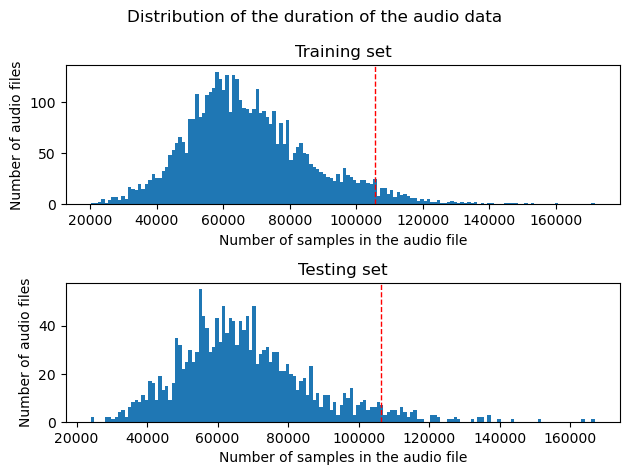

In [169]:
# Plotting time distib of samples in the database

# Stastistic info
mean_train = np.mean(audio_train_duration_list)
mean_test  = np.mean(audio_test_duration_list)
std_train = np.std(audio_train_duration_list)
std_test  = np.std(audio_test_duration_list)

print(f'Mean train:\t {mean_train}\nStd train:\t {std_train}')
print(f'Mean test:\t {mean_test}\nStd test:\t {std_test}')

fig, axs = plt.subplots(2)

axs[0].hist(audio_train_duration_list, bins=150)
axs[0].set_title("Training set")
axs[0].set_xlabel("Number of samples in the audio file")
axs[0].set_ylabel("Number of audio files")
# For the training set, we will truncate at 2 std from the mean all the audio samples which duration 
# is superior to the mean and pad to the choosen length the others
axs[0].axvline(mean_train + 2*std_train, color='r', linestyle='dashed', linewidth=1)


axs[1].hist(audio_test_duration_list, bins=150)
axs[1].set_title("Testing set")
axs[1].set_xlabel("Number of samples in the audio file")
axs[1].set_ylabel("Number of audio files")
axs[1].axvline(mean_test + 2*std_test, color='r', linestyle='dashed', linewidth=1)

fig.suptitle("Distribution of the duration of the audio data")

fig.tight_layout()
plt.show()

In [170]:
def trunc_pad_audio_data(audio_file, truncate_val):

    # truncating
    if audio_file.shape[0] > truncate_val and truncate_val != 0:
        new_audio_file = audio_file[0:truncate_val]

    # padding
    elif audio_file.shape[0] < truncate_val:
        new_audio_file = np.concatenate((audio_file, np.zeros(truncate_val - audio_file.shape[0])), axis=None)

    else:
        return audio_file

    return new_audio_file

In [171]:
# need to encode the characters of the labels (y) into int to convert them to pytorch tensors
def label_encoder(label):
    """
        Use ASCII code to encode in float16 (simpliest way)
        input: -label (string): text
        output: -y_target (torch.Tensor(dtype=torch.float16))
    """
    y_label = [ord(c) for c in label]
    y_target = torch.as_tensor(y_label, dtype=torch.float32)
    
    return y_target


def label_decoder(encoded_label):
    """
        from float16 to ASCII. Take one label at a time in the form of Tensor of size(1, label length).
        input: -encoded_label (torch.Tensor(dtype=torch.float16): tensor containing all float16 corresponding of chars
        output: -y_string (string): decoded string
    """
    y_label = encoded_label.squeeze(0).tolist()
    y_string = ''.join(chr(int(ascii_code)) for ascii_code in y_label)
    
    return y_string


def y_layout(text, vocabulary_list):


    # withdraw the numbers at the beginning
    text = text.split(" ")
    text = text[2:]
    text = " ".join(text)

    # encode in choosen vocabulary adapted to the task of the Neural Network
    clean_text = ''.join([char for char in text if char in vocabulary_list])

    y = clean_text
    # to numpy array
    #y = np.array(clean_text)

    return y


In [172]:
import pickle as pkl

In [173]:
def fill_X_and_y(list_type, vocabulary_list, truncate_val=0):
    """
        type (str): "TRAIN" or "TEST"
    """

    X = []
    y = []

    for path in audio_df["path_from_data_dir"][(audio_df["test_or_train"]==list_type)]:

        # fill X
        audio, sample_rate = librosa.load(path)

        # trunc or pad the audio file
        trunc_audio = trunc_pad_audio_data(audio, truncate_val)

        if list_type == "TEST":
            print(trunc_audio.shape)

        # hop length is set as in the cited paper
        mfcc_spectrogram   = librosa.feature.mfcc(y=trunc_audio, sr=sample_rate, n_fft=254, hop_length=254-128, n_mels=13)

        X.append(torch.from_numpy(mfcc_spectrogram).float().unsqueeze(0).permute(0,2,1))

        # fill y
        path = path.replace("wav", "txt")
        text = open(path, 'r').read()
        # symbolic encoding of y
        text = y_layout(text, vocabulary_list)
        y_target = label_encoder(text)
        y.append(y_target.unsqueeze(0))

    return X, y


def save_datasets(X, y, file_name):

    with open(file_name, "wb") as file:
        pkl.dump([X, y], file)


def load_datasets(file_name):

    with open(file_name, "rb") as file:
        X, y = pkl.load(file)

    return X, y



if __name__=="__main__":

    # blanc element must be in first
    vocabulary = ["-"] + [chr(i) for i in range(65, 91)] + [chr(i) for i in range(97, 123)] + [",", ".", ":", ";", "?"] + [chr(i) for i in range(32, 35)] + ["'"]

    # In vocabulary - stands for the blank item
    print(vocabulary)

    # Statistic info
    # train
    mean_train = np.mean(audio_train_duration_list)
    std_train = np.std(audio_train_duration_list)
    # test
    mean_test  = np.mean(audio_test_duration_list)
    std_test  = np.std(audio_test_duration_list)

    if not os.path.isfile("trunc_pad_train.pkl"):

        X_train, y_train = fill_X_and_y(list_type="TRAIN",vocabulary_list=vocabulary, truncate_val=int(mean_train + 2*std_train))
        file_name = "trunc_pad_train.pkl"
        save_datasets(X_train, y_train, file_name)
        
    else:
        print("Train file already exist")

    if not os.path.isfile("trunc_pad_test.pkl"):

        file_name = "trunc_pad_test.pkl"
        # no need trucating audio files in X_test because all at same length
        X_test, y_test   = fill_X_and_y(list_type="TEST", vocabulary_list=vocabulary, truncate_val=int(mean_test + 2*std_test))
        save_datasets(X_test, y_test, file_name)

    else: 
        print("Test file already exist")
        file_name = "trunc_pad_train.pkl"
        X_train, y_train = load_datasets(file_name)
        file_name = "trunc_pad_test.pkl"
        X_test, y_test   = load_datasets(file_name)


['-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ',', '.', ':', ';', '?', ' ', '!', '"', "'"]
Train file already exist
Test file already exist


In [174]:
print(f'Are labels in train and test datasets the same?\t {y_test == y_train}')

print(f'Nof samples in X_train:\t\t\t {len(X_train)}')
print(f'Nof samples in y_train:\t\t\t {len(y_train)}')
print(f'Nof samples in X_test:\t\t\t {len(X_test)}')
print(f'Nof samples in y_test:\t\t\t {len(y_test)}')

print(f'Shape of X_train items:\t\t\t {X_train[0].shape}')
print(f'Shape of X_test items:\t\t\t {X_test[0].shape}')

print(y_test[1].shape)

max_len_y_test = max([y_test[i].shape[1] for i in range(len(y_test))])
print(f'Maximum length of y_test labels:\t {max_len_y_test}')
max_len_y_train = max([y_train[i].shape[1] for i in range(len(y_train))])
print(f'Maximum length of y_train labels:\t {max_len_y_train}')

print("\n")

encoded_vocabulary = label_encoder(''.join(v for v in vocabulary))
print("vocabulary: \t\t", vocabulary)
print("encoded_vocabulary: \t", encoded_vocabulary)
print("\n")

#Decode target
decoded_target_y_test = label_decoder(y_test[0])
print(f'Decode {y_train[0]} to {decoded_target_y_test}')
print("\n")

#Encode target
encoded_target_y_test = label_encoder(decoded_target_y_test)
print(f'Encode {decoded_target_y_test} to {encoded_target_y_test}')

Are labels in train and test datasets the same?	 False
Nof samples in X_train:			 4620
Nof samples in y_train:			 4620
Nof samples in X_test:			 1680
Nof samples in y_test:			 1680
Shape of X_train items:			 torch.Size([1, 839, 13])
Shape of X_test items:			 torch.Size([1, 845, 13])
torch.Size([1, 44])
Maximum length of y_test labels:	 80
Maximum length of y_train labels:	 80


vocabulary: 		 ['-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ',', '.', ':', ';', '?', ' ', '!', '"', "'"]
encoded_vocabulary: 	 tensor([ 45.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,
         76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
         88.,  89.,  90.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105.,
        106., 107., 108., 109.,

## Modèle

In [175]:
class encoderRNN(nn.Module):

    def __init__(self, input_size, hidden_size=256, output_size=62):
        super().__init__() 
        # input_size = nof features
        self.input_size = input_size
        self.hidden_size = hidden_size

        # batch_first --> shape of input: (batch_size, nof_features, nof_time_frames)
        self.lstm0 = nn.LSTM(input_size, self.hidden_size // 2, num_layers=1,  bidirectional=True, batch_first=True)

        self.lin_layer  = nn.Sequential(nn.Linear(in_features=hidden_size, out_features=output_size),
                                        nn.LogSoftmax(dim=2) 
                                        )

    def forward(self, x):
        # h0 and c0 are of shapes (num_stacked_layers_LSTM, batch_size, hidden_size)
        # hidden = (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))
        x_out, _ = self.lstm0(x)#, hidden) 
        log_logits = self.lin_layer(x_out)

        return log_logits


# Decoder of the output matrix: find the best path with greedy algorithm
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission):
        """Given a sequence emission over labels, get the best path
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          List[str]: The resulting transcript
        """

        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        joined = "".join([self.labels[i] for i in indices])

        return joined.replace("-", " ").strip().split()

## Utils

In [176]:
from torch.autograd import Variable
import torchaudio

In [177]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, file_path, device):
    state_params = torch.load(file_path)
    model.load_state_dict(state_params)

def train_epoch(model, optimizer, criterion, 
                X_train, y_train, batch_size,
                device):

    running_loss = 0.0

    model.train()

    for X, y_target in zip(X_train, y_train):

        X, y_target = Variable(X.to(device)), Variable(y_target.to(device))
        optimizer.zero_grad()
        y_predicted = model(X)

        # Loss: CTC objective function
        transcription_length  = y_target.shape[1]
        transcription_lengths = torch.full((batch_size,), transcription_length, dtype=torch.long)

        audio_length  = X.shape[1]
        audio_lengths = torch.full((batch_size,), audio_length, dtype=torch.long)

        # in loss, size of predicted must be (time seq len, batch size, nof items in vocabulary)
        y_predicted = y_predicted.permute(1,0,2)
        loss = criterion(y_predicted, y_target, audio_lengths, transcription_lengths)
        loss.backward()

        optimizer.step()
        running_loss += loss.item()

    return running_loss / len(X_train)
    

def valid_epoch(model, optimizer, criterion, 
                decoder_ctc, #greedy, beam search, etc.
                X_test, y_test, batch_size,
                epoch,
                device):
    
    running_loss = 0.0
    accuracy     = 0.0

    model.eval()

    with torch.no_grad():
        for X, y_target in zip(X_test, y_test):

            X, y_target = X.to(device), y_target.to(device)
            y_predicted = model(X)

            # Loss: CTC objective function
            transcription_length  = y_target.shape[1]
            transcription_lengths = torch.full((batch_size,), transcription_length, dtype=torch.long)
            audio_length  = X.shape[1]
            audio_lengths = torch.full((batch_size,), audio_length, dtype=torch.long)
            y_predicted = y_predicted.permute(1,0,2)

            # Computing the loss of the epoch
            loss = criterion(y_predicted, y_target, audio_lengths, transcription_lengths)
            running_loss += loss.item()

            # Accuracy
            greedy_result     = decoder_ctc(y_predicted.squeeze(1))
            greedy_transcript = " ".join(greedy_result)
            greedy_wer = torchaudio.functional.edit_distance(y_target, greedy_result) / len(y_target)

    mean_loss = running_loss / len(X_test)
    accuracy = greedy_wer

    print(f"Last transcript in the epoch {epoch}: {greedy_transcript}")
    print(f"Last target: {label_decoder(y_target)}")
    
    return accuracy, mean_loss


def training_function(model, train_dataset, test_dataset,
                      nof_epochs, batch_size,
                      optimizer, learning_rate, criterion, decoder_ctc,
                      file_path_save_model,
                      device):

    print("Starting training...\n")

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    model.to(device)

    best_accuracy = 0.0

    for epoch in range(1, nof_epochs+1):

        epoch_accuracy  = 0.0
        train_epoch_loss      = 0.0
        test_epoch_loss = 0.0

        #Training
        train_epoch_loss = train_epoch(model, optimizer, criterion, 
                                       train_dataset[0], train_dataset[1], batch_size, 
                                       device)
        
        #Validation
        epoch_accuracy, test_epoch_loss = valid_epoch(model, optimizer, criterion, decoder_ctc,
                                     test_dataset[0], test_dataset[1], batch_size,
                                     epoch, device)
    
        
        print('Epoch', epoch,', train loss: {:.4f}, WER: {:.4f}, test loss: {:.4f} % \n'.format(train_epoch_loss, epoch_accuracy, test_epoch_loss))
        
        #Save model when best accuracy is beaten
        if epoch_accuracy > best_accuracy:
            save_epoch_path = str(epoch) + "best_accuracy.pth"
            save_model(model, save_epoch_path)
            best_accuracy = epoch_accuracy

    # Saving the model
    print('Saving the model...\n')
    model = model.to('cpu')
    save_model(model, file_path_save_model)

    print("Training finish.\n") 

    return model


def save_checkpoint_model(model,
                          optimizer, loss,
                          epoch,
                          file_path):
    """
        Function to save model's checkpoints
    """
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss}, 
                file_path)



def load_checkpoint_model(model,
                          optimizer, loss,
                          epoch, 
                          device, file_path):

    checkpoint = torch.load(file_path)

    #Loading
    model.load_state_dict(checkpoint['model_state_dict'], map_location=device)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'], map_location=device)
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    return epoch, loss


def plot_results():
    plt.show()
    raise NotImplemented

## Main

In [178]:
from torchsummary import summary
import torch.nn as nn

In [179]:
if __name__=="__main__":

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Data
    file_name = "trunc_pad_train.pkl"
    X_train, y_train = load_datasets(file_name)
    file_name = "trunc_pad_test.pkl"
    X_test, y_test   = load_datasets(file_name)
    train_dataset = [X_train, y_train]
    test_dataset  = [X_test, y_test]

    # Model
    input_layer  = 13 #X_train[0].shape[0] 
    hidden_size  = 256
    output_layer = len(vocabulary)
    model        = encoderRNN(input_layer, hidden_size, output_layer)

    summary(model, (1, 839, 13), batch_dim=None)
    print("\n")

    # Training  
    nof_epochs           = 5
    batch_size           = 1
    ctc_loss             = nn.CTCLoss(reduction='mean')
    criterion            = ctc_loss
    # Getting the interpretetion of the output of the NN
    greedy_decoder = GreedyCTCDecoder(vocabulary)#encoded vocab test)
    learning_rate        = 0.1
    optimizer            = torch.optim.Adam(model.parameters(), lr = learning_rate)
    file_path_save_model = "full_training_RNN_encoder.pth"

    trained_model = training_function(model, train_dataset, test_dataset, 
                                      nof_epochs, batch_size,
                                      optimizer, learning_rate, criterion, greedy_decoder,
                                      file_path_save_model,
                                      device)
                    

Layer (type:depth-idx)                   Output Shape              Param #
├─LSTM: 1-1                              [1, 839, 256]             146,432
├─Sequential: 1-2                        [1, 839, 62]              --
|    └─Linear: 2-1                       [1, 839, 62]              15,934
|    └─LogSoftmax: 2-2                   [1, 839, 62]              --
Total params: 162,366
Trainable params: 162,366
Non-trainable params: 0
Total mult-adds (M): 0.18
Input size (MB): 0.04
Forward/backward pass size (MB): 2.04
Params size (MB): 0.62
Estimated Total Size (MB): 2.70


Starting training...

The model will be running on cuda:0 device
Last transcript in the epoch 1: Vt
Last target: The carpet cleaners shampooed our oriental rug.
Epoch 1 , train loss: 38.9626, WER: 1.0000, test loss: 7.0211 % 

Last transcript in the epoch 2: Vft
Last target: The carpet cleaners shampooed our oriental rug.
Epoch 2 , train loss: 32.4243, WER: 1.0000, test loss: 6.9143 % 

Last transcript in the epoch 3: